<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Web APIs & Classification

## Problem Statement

Reddit is a massive global online forum with a heavy focus on its communities. These communities are divided into subreddits with each being specific to a certain subject. The variety of the subreddit topics can range from an educational data science subreddit to art, books, memes and video games. As of 2020, reddit has over [53 million](https://www.redditinc.com/) daily active users worldwide.

Each subreddit usually has many moderators and admins moderating the posts to ensure that they meet the subreddit rules. With an ever-increasing userbase, the process of moderating these posts are becoming more and more cumbersome requiring greater amount of manpower to ensure the posts are not offtopics and meet the rules.

In this project, I am proposing the viability of using a machine learning classification model to help distinguishing posts for two different subreddits. We will be looking at applying it to two of the biggest film franchises **r/harrypotter** and **r/lotr**. We will evaluating to see if we can use the texts and language used in the post's title/body(selftext) to classify whether it belongs in r/harrypotter or r/lotr. This project will only be using text features within a post to classify as this is a consistent feature across new posts.

- **r/harrpotter** is the place where fans from around the world can meet and discuss everything in the Harry Potter universe! (992k subscribers)

- **r/lotr** is a subreddit for all things related to Tolkien, Lord of The Rings, and The Hobbit universe. (522k subscribers)





## Importing Packages

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV
from sklearn.pipeline import Pipeline
from nltk.tokenize import RegexpTokenizer
import matplotlib.style as style
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import roc_curve, auc,plot_roc_curve,f1_score
from wordcloud import WordCloud
import random

In [2]:
style.use('ggplot')



## Datasets

The datasets for r/harrypotter and r/lotr were obtained from reddit API.

The project contains two datasets. These datasets contain the information of the individual posts on each subreddit. The original datasets contain 114 columns. However, we will only be selecting a subset 19 relevant columns.
- harrypotter.csv (865 posts)
- lotr.csv (1134 posts)

| Column                | Type   | Description                                             |
|-----------------------|--------|---------------------------------------------------------|
| id                    | string | post's unique identifier                                |
| title                 | string | post's title                                            |
| selftext              | string | post's text content                                     |
| created_utc           | float  | time post was created in UTC epoch-second               |
| author_premium        | bool   | True if author has Reddit Premium account               |
| link_flair_css_class  | string | tags of the post (eg. discussion, announcement, question, events, news)        |
| score                 | int    | the net-score of the post (ups - downs)                 |
| upvote_ratio          | float  | ratio of upvotes                                        |
| num_crossposts        | int    | number of times the post was shared on other subreddits |
| total_awards_received | int    | number of awards the post received                      |
| num_reports           | float  | number of reports the post received                     |
| ups                   | int    | number of upvotes                                       |
| downs                 | int    | number of downvotes                                     |
| num_comments          | int    | number of comments in the post                          |
| gilded                | int    | number of reddit gold received (award)                  |
| spoiler               | bool   | True if the post contains spoilers                      |
| is_video              | bool   | True if the post contains videos                        |
| post_hint             | string | post's hints (videos, images, links, etc.)                                   |
| subreddit             | string | name of the subreddit                                   |

The datatypes of the columns are as follow:
- **5 strings**: title, selftext, subreddit, ...
- **3 bools**: spoiler, author_premium, is_video
- **3 floats**: upvote_ratio, num_reports, ...
- **7 ints**: ups (upvotes), downs (downvotes), num_comments, ...

In [119]:
features = ['id','title','selftext','created_utc','author_premium','link_flair_css_class','score','upvote_ratio',
            'num_crossposts','total_awards_received','num_reports','ups','downs','num_comments','gilded','spoiler',
           'is_video','subreddit','post_hint']

In [120]:
lotr_df = pd.read_csv('lotr.csv',usecols=features)
lotr_df = lotr_df[features] #Ordering the columns
lotr_df.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,num_reports,ups,downs,num_comments,gilded,spoiler,is_video,subreddit,post_hint
0,bu0fgg,"Mod Post Update: No Memes, No Politics, and No...",Just updating the mod post to remind people th...,1.559052e+09,False,NaN,418,1.00,0,0,NaN,418,0,28,0,False,False,lotr,NaN
1,m563uh,Viggo with Fon who played the scale double for...,NaN,1.615761e+09,False,NaN,4800,0.99,0,5,NaN,4800,0,34,0,False,False,lotr,image
2,m5bw4b,For my birthday my wife tried her hand at maki...,NaN,1.615780e+09,False,NaN,91,1.00,0,0,NaN,91,0,8,0,False,False,lotr,image
3,m5f5wi,"Just started reading The Hobbit to my kids, ag...",NaN,1.615793e+09,False,NaN,24,0.95,0,0,NaN,24,0,3,0,False,False,lotr,NaN
4,m5bicl,What are the odds 😂,NaN,1.615778e+09,False,NaN,29,0.97,0,0,NaN,29,0,6,0,False,False,lotr,image


In [121]:
lotr_df.shape

(865, 19)

In [122]:
lotr_df.drop_duplicates(subset=['id'],inplace=True)
lotr_df.shape

(739, 19)

Interpretation: The dataset from the subreddit 'r/depression' contained 126 duplicates. The duplicates were removed.

In [123]:
harrypotter_df = pd.read_csv('harrypotter.csv',usecols=features)
harrypotter_df = harrypotter_df[features] #Ordering the columns
harrypotter_df.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,num_reports,ups,downs,num_comments,gilded,spoiler,is_video,subreddit,post_hint
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",1.609479e+09,False,announcement,185,0.99,1,4,NaN,185,0,16,0,False,False,harrypotter,NaN
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,1.615774e+09,False,discussion,1088,0.98,0,1,NaN,1088,0,43,0,False,False,harrypotter,NaN
2,m5euwp,snape,NaN,1.615791e+09,False,dungbomb,314,0.96,0,2,NaN,314,0,8,0,False,False,harrypotter,image
3,m5236j,I always wonder how often it happens that some...,NaN,1.615750e+09,False,discussion,1347,0.99,0,1,NaN,1347,0,48,0,False,False,harrypotter,NaN
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,1.615730e+09,False,discussion,3144,0.98,0,6,NaN,3144,0,356,0,False,False,harrypotter,NaN


In [124]:
harrypotter_df.shape

(1134, 19)

In [125]:
harrypotter_df.drop_duplicates(subset=['id'],inplace=True)
harrypotter_df.shape

(984, 19)

Interpretation: The dataset from the subreddit 'r/sad' contained 127 duplicates. The duplicates were removed.

### Combining the two dataframes

Combining r/harrypotter and r/lotr to make it easier to work with.

In [126]:
combined = harrypotter_df.append(lotr_df)
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,num_reports,ups,downs,num_comments,gilded,spoiler,is_video,subreddit,post_hint
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",1.609479e+09,False,announcement,185,0.99,1,4,NaN,185,0,16,0,False,False,harrypotter,NaN
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,1.615774e+09,False,discussion,1088,0.98,0,1,NaN,1088,0,43,0,False,False,harrypotter,NaN
2,m5euwp,snape,NaN,1.615791e+09,False,dungbomb,314,0.96,0,2,NaN,314,0,8,0,False,False,harrypotter,image
3,m5236j,I always wonder how often it happens that some...,NaN,1.615750e+09,False,discussion,1347,0.99,0,1,NaN,1347,0,48,0,False,False,harrypotter,NaN
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,1.615730e+09,False,discussion,3144,0.98,0,6,NaN,3144,0,356,0,False,False,harrypotter,NaN


In [127]:
combined.shape

(1723, 19)

In [128]:
combined.reset_index(inplace=True,drop=True)

In [129]:
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,num_reports,ups,downs,num_comments,gilded,spoiler,is_video,subreddit,post_hint
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",1.609479e+09,False,announcement,185,0.99,1,4,NaN,185,0,16,0,False,False,harrypotter,NaN
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,1.615774e+09,False,discussion,1088,0.98,0,1,NaN,1088,0,43,0,False,False,harrypotter,NaN
2,m5euwp,snape,NaN,1.615791e+09,False,dungbomb,314,0.96,0,2,NaN,314,0,8,0,False,False,harrypotter,image
3,m5236j,I always wonder how often it happens that some...,NaN,1.615750e+09,False,discussion,1347,0.99,0,1,NaN,1347,0,48,0,False,False,harrypotter,NaN
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,1.615730e+09,False,discussion,3144,0.98,0,6,NaN,3144,0,356,0,False,False,harrypotter,NaN


## Preprocessing

#### Checking for missing values

In [130]:
combined.shape

(1723, 19)

In [131]:
combined.isna().sum()[combined.isna().sum() > 0].sort_values(ascending=False)

num_reports             1723
post_hint               1093
selftext                 790
link_flair_css_class     739
author_premium            18
dtype: int64

Interpretation: post_hints has classes that indicate if a post contains rich media such as images and videos. The missing values indicate that the post only contains texts. We will not be filling N/A for these values as we will be creating a new column based off these data in a later step.

In [132]:
combined.drop(columns=['num_reports'],inplace=True)
combined.shape

(1723, 18)

Interpretation: We can see that 'num_reports' are all missing. Thus we will drop this column. Despite the fact that there are a lot of missing values for 'selftext' and 'link_flair_css_class', we will not be dropping these as these text-based column will be used to join with the title later the steps.

In [133]:
combined['author_premium'].value_counts(normalize=True)

False    0.929619
True     0.070381
Name: author_premium, dtype: float64

Interpretation: As seen here, the majority of people (92%) who posted in *r/harrypotter* and *r/lotr* do not have Reddit Premium accounts. We will use this information to fill the missing values for 'author_premium' to False.

In [134]:
combined['author_premium'] = combined['author_premium'].fillna(False)

In [135]:
combined['author_premium'].isna().sum()

0

The selftext contains the posts' extra text contents that people can put within a post. Sometimes, the title is self explanatory and thus no selftext is entered. Therefore, we will be replacing these missing values with an empty string.

In [136]:
combined['selftext'].fillna('',inplace=True)

In [137]:
combined['selftext'].isna().sum()

0

The flair contains the tags for posts that can be used to filter content based on the category of the post. Posts are not required to have tags so we will be replacing these missing values with an empty string.

In [138]:
combined['link_flair_css_class'].fillna('',inplace=True)

In [139]:
combined['link_flair_css_class'].isna().sum()

0

#### Converting bools columns to 0/1

In [140]:
bool_cols = combined.select_dtypes('bool').columns

In [141]:
combined[bool_cols] = combined.select_dtypes('bool').astype(int)
combined[bool_cols].head()

,author_premium,spoiler,is_video
0,0,0,0
1,0,0,0
2,0,0,0
3,0,0,0
4,0,0,0


#### Creating a new column to indicate whether a post contain rich media such as videos and images

In [143]:
combined['post_hint'].value_counts()

image           467
rich:video       56
self             47
link             31
hosted:video     28
gallery           1
Name: post_hint, dtype: int64

In [152]:
combined['contains_media'] = combined['post_hint'].map({'image':1,'rich:video':1,'self':1,'link':1,'hosted:video':1,'gallery':1,np.nan:0})
combined['contains_media'].value_counts()

0    1093
1     630
Name: contains_media, dtype: int64

In [240]:
combined['contains_media'].value_counts(normalize=True)

0    0.634359
1    0.365641
Name: contains_media, dtype: float64

Interpretation: The numbers above show that there are 1093 (63%) text based posts and 630 (37%) rich (videos,images,links) posts.

#### Converting 'created_utc' to datetime

In [153]:
# Converting the Epoch Seconds time in the 'created_utc' column to datetime
combined['created_utc'] = pd.to_datetime(combined['created_utc'],unit='s', origin='unix')
combined['created_utc'].head()

0   2021-01-01 05:24:30
1   2021-03-15 02:03:15
2   2021-03-15 06:56:39
3   2021-03-14 19:26:02
4   2021-03-14 13:48:08
Name: created_utc, dtype: datetime64[ns]

#### Extracting Day of the Week from 'created_utc'

In [154]:
combined['day_str'] = (combined['created_utc'].dt.dayofweek).map({0:'Mon',1:'Tues',2:'Weds',3:'Thurs',4:'Fri',5:'Sat',6:'Sun'})

In [155]:
combined['day_int'] = (combined['created_utc'].dt.dayofweek)

In [156]:
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,downs,num_comments,gilded,spoiler,is_video,subreddit,post_hint,contains_media,day_str,day_int
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",2021-01-01 05:24:30,0,announcement,185,0.99,1,4,...,0,16,0,0,0,harrypotter,NaN,0,Fri,4
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,2021-03-15 02:03:15,0,discussion,1088,0.98,0,1,...,0,43,0,0,0,harrypotter,NaN,0,Mon,0
2,m5euwp,snape,,2021-03-15 06:56:39,0,dungbomb,314,0.96,0,2,...,0,8,0,0,0,harrypotter,image,1,Mon,0
3,m5236j,I always wonder how often it happens that some...,,2021-03-14 19:26:02,0,discussion,1347,0.99,0,1,...,0,48,0,0,0,harrypotter,NaN,0,Sun,6
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,2021-03-14 13:48:08,0,discussion,3144,0.98,0,6,...,0,356,0,0,0,harrypotter,NaN,0,Sun,6


### Creating binary Target variable ('is_harrypotter')

- 1: r/harrypotter subreddit
- 0: r/lotr subreddit

In [157]:
combined['subreddit'].value_counts(normalize=True)

harrypotter    0.571097
lotr           0.428903
Name: subreddit, dtype: float64

Interpretation: Although the subreddit classes may not be perfectly balanced, 57:43 is still an acceptable proportion to use in our models.

In [158]:
combined['is_harrypotter'] = combined['subreddit'].map({'harrypotter':1,'lotr':0})

In [159]:
combined.drop(columns=['subreddit'],inplace=True)

In [160]:
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,downs,num_comments,gilded,spoiler,is_video,post_hint,contains_media,day_str,day_int,is_harrypotter
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",2021-01-01 05:24:30,0,announcement,185,0.99,1,4,...,0,16,0,0,0,NaN,0,Fri,4,1
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,2021-03-15 02:03:15,0,discussion,1088,0.98,0,1,...,0,43,0,0,0,NaN,0,Mon,0,1
2,m5euwp,snape,,2021-03-15 06:56:39,0,dungbomb,314,0.96,0,2,...,0,8,0,0,0,image,1,Mon,0,1
3,m5236j,I always wonder how often it happens that some...,,2021-03-14 19:26:02,0,discussion,1347,0.99,0,1,...,0,48,0,0,0,NaN,0,Sun,6,1
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,2021-03-14 13:48:08,0,discussion,3144,0.98,0,6,...,0,356,0,0,0,NaN,0,Sun,6,1


In [161]:
combined['is_harrypotter'].value_counts()

1    984
0    739
Name: is_harrypotter, dtype: int64

In [162]:
combined['text'] = combined.apply(lambda row: str(row['title']) + " " + str(row['selftext']) ,axis=1)
combined['text'].head()

0    Happy New Year! Please enjoy the Winter 2021 Q...
1    The intro to the first book is utter perfectio...
2                                               snape 
3    I always wonder how often it happens that some...
4    The Other Minister The other minister is my fa...
Name: text, dtype: object

Interpretation: We are concatinating the title/selftext columns into a single column called 'text' so that we will have more text data to work with.

In [163]:
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,num_comments,gilded,spoiler,is_video,post_hint,contains_media,day_str,day_int,is_harrypotter,text
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",2021-01-01 05:24:30,0,announcement,185,0.99,1,4,...,16,0,0,0,NaN,0,Fri,4,1,Happy New Year! Please enjoy the Winter 2021 Q...
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,2021-03-15 02:03:15,0,discussion,1088,0.98,0,1,...,43,0,0,0,NaN,0,Mon,0,1,The intro to the first book is utter perfectio...
2,m5euwp,snape,,2021-03-15 06:56:39,0,dungbomb,314,0.96,0,2,...,8,0,0,0,image,1,Mon,0,1,snape
3,m5236j,I always wonder how often it happens that some...,,2021-03-14 19:26:02,0,discussion,1347,0.99,0,1,...,48,0,0,0,NaN,0,Sun,6,1,I always wonder how often it happens that some...
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,2021-03-14 13:48:08,0,discussion,3144,0.98,0,6,...,356,0,0,0,NaN,0,Sun,6,1,The Other Minister The other minister is my fa...


In [164]:
combined.to_csv('datasets/combined.csv')

## EDA

### Summary

In [165]:
combined.describe()

,author_premium,score,upvote_ratio,num_crossposts,total_awards_received,ups,downs,num_comments,gilded,spoiler,is_video,contains_media,day_int,is_harrypotter
count,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.0,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000,1723.000000
mean,0.069646,319.720255,0.790696,0.038305,0.761463,319.720255,0.0,16.377829,0.003482,0.020894,0.016251,0.365641,3.379571,0.571097
std,0.254623,1568.574686,0.209846,0.267773,3.310224,1568.574686,0.0,44.495984,0.058925,0.143070,0.126475,0.481749,2.130984,0.495063
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.670000,0.000000,0.000000,2.000000,0.0,3.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,0.000000,8.000000,0.860000,0.000000,0.000000,8.000000,0.0,6.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000
75%,0.000000,44.000000,0.970000,0.000000,0.000000,44.000000,0.0,14.000000,0.000000,0.000000,0.000000,1.000000,5.000000,1.000000
max,1.000000,23706.000000,1.000000,4.000000,57.000000,23706.000000,0.0,910.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000


Interpretation: Looking at the summary, we can see that there are around 7% of premium users who posted in these two subreddits. The mean score of the posts is 319 with an average upvote ratio of 0.79. The score is derived from upvotes (ups) - downvotes (downs). However, the API does not seem to be showing any downvotes (downs) in any of the post which is highly unlikely. This could be due to the decision by reddit API developers to not give away downvotes information. This is also the reason why score = ups.

There are is an average (mean) of 16 comments on each post. Some of the posts contain videos as well accounting for 1.6% of all the posts. 

In [166]:
#Harry Potter data summary
combined[combined['is_harrypotter']==1].describe()

,author_premium,score,upvote_ratio,num_crossposts,total_awards_received,ups,downs,num_comments,gilded,spoiler,is_video,contains_media,day_int,is_harrypotter
count,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.0,984.000000,984.000000,984.000000,984.000000,984.000000,984.000000,984.0
mean,0.051829,210.834350,0.732337,0.023374,0.419715,210.834350,0.0,17.956301,0.002033,0.033537,0.007114,0.201220,3.680894,1.0
std,0.221795,1466.789446,0.213973,0.181725,2.050149,1466.789446,0.0,49.212777,0.045061,0.180125,0.084086,0.401116,2.093880,0.0
min,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,0.000000,1.000000,0.600000,0.000000,0.000000,1.000000,0.0,4.000000,0.000000,0.000000,0.000000,0.000000,2.000000,1.0
50%,0.000000,5.000000,0.770000,0.000000,0.000000,5.000000,0.0,8.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.0
75%,0.000000,21.000000,0.920000,0.000000,0.000000,21.000000,0.0,16.000000,0.000000,0.000000,0.000000,0.000000,6.000000,1.0
max,1.000000,23706.000000,1.000000,3.000000,24.000000,23706.000000,0.0,910.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.0


In [167]:
#Lord of the Rings data summary
combined[combined['is_harrypotter']==0].describe()

,author_premium,score,upvote_ratio,num_crossposts,total_awards_received,ups,downs,num_comments,gilded,spoiler,is_video,contains_media,day_int,is_harrypotter
count,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.0,739.000000,739.000000,739.000000,739.000000,739.000000,739.000000,739.0
mean,0.093369,464.705007,0.868403,0.058187,1.216509,464.705007,0.0,14.276049,0.005413,0.004060,0.028417,0.584574,2.978349,0.0
std,0.291146,1684.762573,0.176571,0.350180,4.427886,1684.762573,0.0,37.230216,0.073422,0.063628,0.166273,0.493129,2.115132,0.0
min,0.000000,0.000000,0.100000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
25%,0.000000,4.000000,0.810000,0.000000,0.000000,4.000000,0.0,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.0
50%,0.000000,22.000000,0.950000,0.000000,0.000000,22.000000,0.0,5.000000,0.000000,0.000000,0.000000,1.000000,3.000000,0.0
75%,0.000000,81.500000,0.990000,0.000000,0.000000,81.500000,0.0,11.000000,0.000000,0.000000,0.000000,1.000000,5.000000,0.0
max,1.000000,15943.000000,1.000000,4.000000,57.000000,15943.000000,0.0,448.000000,1.000000,1.000000,1.000000,1.000000,6.000000,0.0


Interpretation: The two tables above show the summary of posts from r/harrypotter and r/lotr. There are 984 r/harrypotter posts and 739 r/lotr posts. On average, we can see that posts from r/lotr generated more score/upvotes than those from r/harrypotter with the mean score of 465 and 211 respectively. However, it seems that r/harrypotter posts created more discussion than posts in r/lotr. A post in r/harrypotter has 18 comments on average compared to r/lotr's 14. A larger proportion of posts in r/lotr are videos accounting for around 3% of the posts in that subreddit. This is more than r/harrypotter's video posts which accounts for less than 1%.

### Heatmap

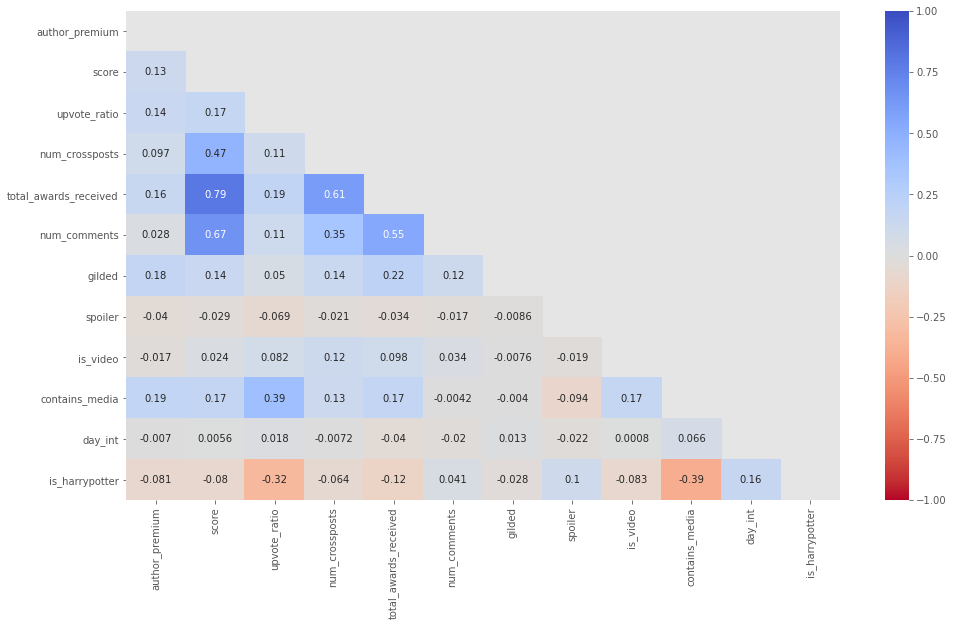

In [168]:
plt.figure(figsize=(16,9))
corr = combined.drop(columns=['downs','ups']).corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = 1
sns.heatmap(corr,mask=mask,cmap='coolwarm_r',annot=True,vmin=-1,vmax=1);

Interpretation: In the above heatmap, it can be clearly seen that the majority of the features are unrelated. Most of them display light blue/orange colours indicating a near 0 correlation. However there are some noticeable correlations in features such as...
- 'total_awards_received' and 'score' => the higher the awards that a post receives, the higher the score
- 'score' and 'num_comments'/'num_crosspost' => posts with higher scores may indicate they they are interesting and thus draws more conversations which results in the post being shared elsewhere.
- 'is_harrypotter' and 'upvote_ratio' => a post that has higher upvote ratio is slightly more likely to be from r/lotr
- 'is_harrypotter' and 'contains_media' => a post is more likely to be from r/harrypotter if it does not contain videos/images/links

In [169]:
combined.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,num_comments,gilded,spoiler,is_video,post_hint,contains_media,day_str,day_int,is_harrypotter,text
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",2021-01-01 05:24:30,0,announcement,185,0.99,1,4,...,16,0,0,0,NaN,0,Fri,4,1,Happy New Year! Please enjoy the Winter 2021 Q...
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,2021-03-15 02:03:15,0,discussion,1088,0.98,0,1,...,43,0,0,0,NaN,0,Mon,0,1,The intro to the first book is utter perfectio...
2,m5euwp,snape,,2021-03-15 06:56:39,0,dungbomb,314,0.96,0,2,...,8,0,0,0,image,1,Mon,0,1,snape
3,m5236j,I always wonder how often it happens that some...,,2021-03-14 19:26:02,0,discussion,1347,0.99,0,1,...,48,0,0,0,NaN,0,Sun,6,1,I always wonder how often it happens that some...
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,2021-03-14 13:48:08,0,discussion,3144,0.98,0,6,...,356,0,0,0,NaN,0,Sun,6,1,The Other Minister The other minister is my fa...


#### Posts Period

In [170]:
combined['created_utc'].agg(['min','max'])

min   2019-05-28 14:05:47
max   2021-03-15 09:05:24
Name: created_utc, dtype: datetime64[ns]

Interpretation: The dataset has the creation period of between 28/05/2019 and 15/03/2021.

#### Most Active Days

In [171]:
combined['day_str'].value_counts(normalize=True)

Sun      0.212420
Sat      0.191526
Mon      0.145096
Fri      0.134068
Weds     0.114335
Tues     0.112594
Thurs    0.089959
Name: day_str, dtype: float64

In [172]:
combined['day_str'].value_counts()

Sun      366
Sat      330
Mon      250
Fri      231
Weds     197
Tues     194
Thurs    155
Name: day_str, dtype: int64

In [173]:
combined_day = combined['day_str']

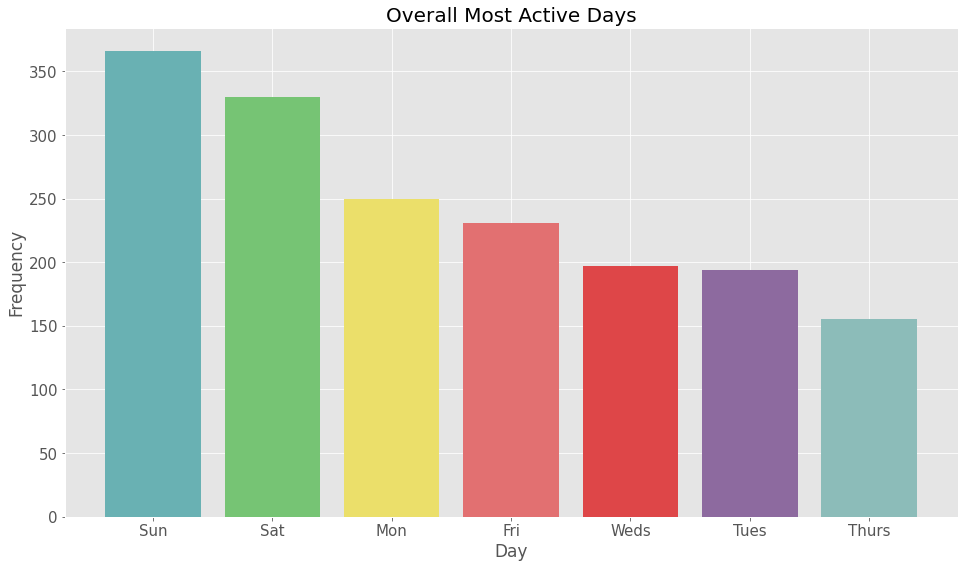

In [174]:
plt.figure(figsize=(16,9))
plt.bar(combined_day.value_counts().index,combined_day.value_counts().values,color=['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9'])
plt.xlabel('Day',size = 17)
plt.ylabel('Frequency',size = 17)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Overall Most Active Days',size = 20);

In [175]:
harry_day = combined.loc[combined['is_harrypotter'] == 1]['day_str'].value_counts()

In [176]:
lotr_day = combined.loc[combined['is_harrypotter'] == 0]['day_str'].value_counts()

In [177]:
dayorder = ['Mon', 'Tues', 'Weds', 'Thurs', 'Fri', 'Sat','Sun']

In [178]:
lotr_day = [item[1] for item in sorted(lotr_day.to_dict().items(), key=lambda i:dayorder.index(i[0]))]
lotr_day

[126, 113, 94, 77, 93, 119, 117]

In [179]:
harry_day = [item[1] for item in sorted(harry_day.to_dict().items(), key=lambda i:dayorder.index(i[0]))]
harry_day

[124, 81, 103, 78, 138, 211, 249]

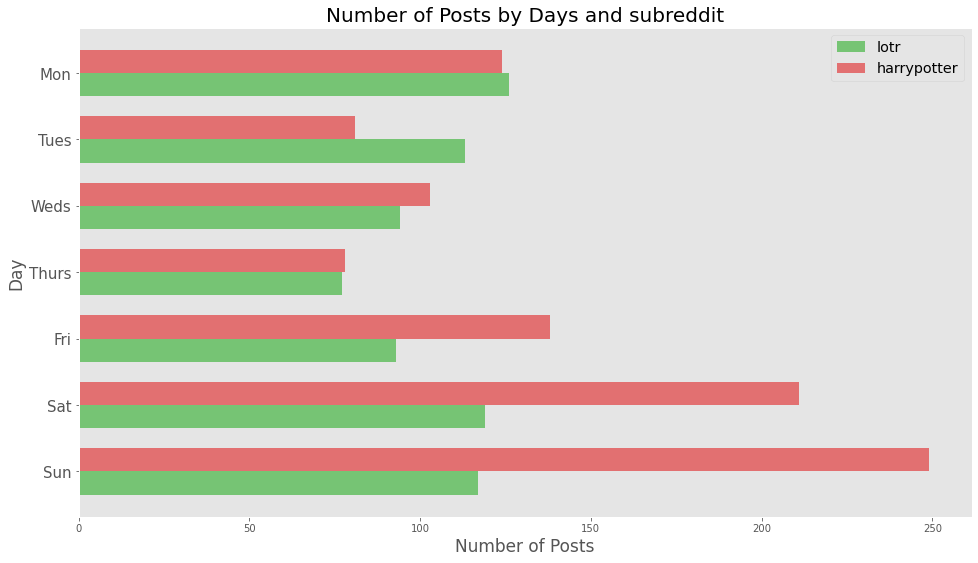

In [180]:
ind = np.arange(7)  # the x locations for the groups
width = 0.35       # the width of the bars

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, lotr_day[::-1], width, color='#76c474')
rects2 = ax.barh(ind+width, harry_day[::-1], width, color='#e27071')


# add some
ax.set_ylabel('Day', size = 17)
ax.set_xlabel('Number of Posts', size = 17)
ax.set_title('Number of Posts by Days and subreddit', size = 20)
ax.set_yticks(ind + 0.5*width )
ax.set_yticklabels(['Mon','Tues','Weds','Thurs','Fri','Sat','Sun'][::-1],size=15)
ax.legend( (rects1[0], rects2[0]), ('lotr', 'harrypotter'),fontsize = 'x-large')
plt.grid(axis='both',which='both',alpha=0.5)
plt.show()

Interpretation: As can be seen from the above figures, weekends are the most popular days to post. Sunday makes up 21% of all the posts, while Saturday makes up 19% of all the posts. Overall weekend posts account for approximately 40%. This is expected as people tend to have more free time during weekends. The day with the lowest number of posts are during the middle of the week on Wednesday and Thursday. This trend is the same for both subreddits. In general, harrypotter has more posts during the period of 28/05/2019 and 15/03/2021.

### Distribution of Post Score

In [181]:
combined['score'].describe()

count     1723.000000
mean       319.720255
std       1568.574686
min          0.000000
25%          2.000000
50%          8.000000
75%         44.000000
max      23706.000000
Name: score, dtype: float64

D:\Users\Boss\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


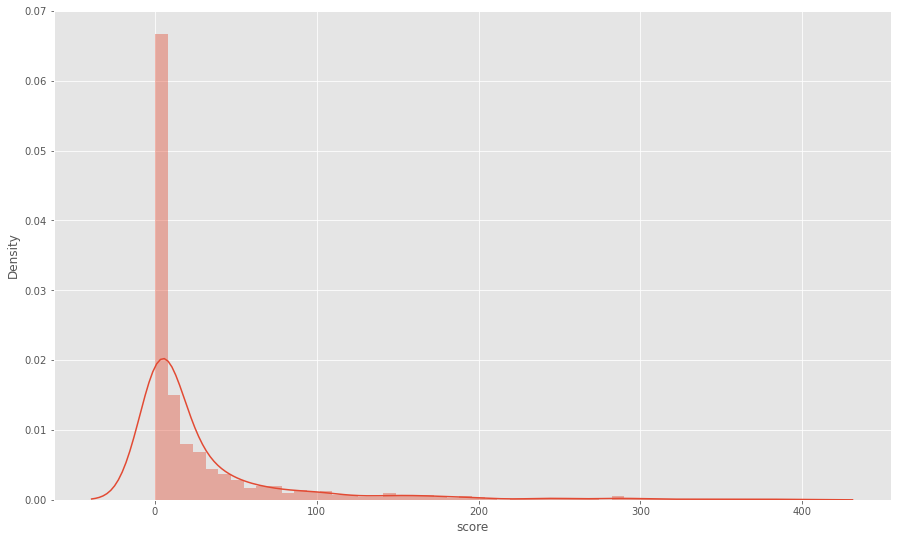

In [182]:
plt.figure(figsize=(15,9))
sns.distplot(combined.loc[combined['score'] < 400,'score']);

Interpretation: Here we can see that the majority of posts have ~ 0 upvotes. The distribution plot clearly shows that it is right skewed. We have only filtered to show the ones that have less than 400 since the remaining distribution looks very similar to the current graph. The calculation in the table shows that the mean (319) is far higher than the median (8) confirming that the distribution of scores is right skewed.

### Words Frequency

In [183]:
# This function is only used here so that we can use it with CountVectorizer to get a word count for WordCloud

def clean_text_no_stemming(text):  
    
    # 1. Remove non-letters.
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    
    #Removing the word 'harrypotter' and 'lotr' from text to avoid the model learning from these words
    text = text.replace('harrypotter',' ')
    text = text.replace('lotr',' ')
    
    # 2. Convert to lower case, split into individual words.
    #words = letters_only.lower().split()
    
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [184]:
cvec = CountVectorizer(binary=True)

In [185]:
harrypotter_df_cleaned = combined.loc[combined['is_harrypotter'] == 1]
harrypotter_df_cleaned.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,num_comments,gilded,spoiler,is_video,post_hint,contains_media,day_str,day_int,is_harrypotter,text
0,ko5pyi,Happy New Year! Please enjoy the Winter 2021 Q...,"#HAPPY NEW YEAR, dear readers!\n\nIt is I, Mad...",2021-01-01 05:24:30,0,announcement,185,0.99,1,4,...,16,0,0,0,NaN,0,Fri,4,1,Happy New Year! Please enjoy the Winter 2021 Q...
1,m5a5n3,The intro to the first book is utter perfection,I love it so much. So many books will jump str...,2021-03-15 02:03:15,0,discussion,1088,0.98,0,1,...,43,0,0,0,NaN,0,Mon,0,1,The intro to the first book is utter perfectio...
2,m5euwp,snape,,2021-03-15 06:56:39,0,dungbomb,314,0.96,0,2,...,8,0,0,0,image,1,Mon,0,1,snape
3,m5236j,I always wonder how often it happens that some...,,2021-03-14 19:26:02,0,discussion,1347,0.99,0,1,...,48,0,0,0,NaN,0,Sun,6,1,I always wonder how often it happens that some...
4,m4vblg,The Other Minister,The other minister is my favourite chapter of ...,2021-03-14 13:48:08,0,discussion,3144,0.98,0,6,...,356,0,0,0,NaN,0,Sun,6,1,The Other Minister The other minister is my fa...


In [186]:
lotr_df_cleaned = combined.loc[combined['is_harrypotter'] == 0]
lotr_df_cleaned.head()

,id,title,selftext,created_utc,author_premium,link_flair_css_class,score,upvote_ratio,num_crossposts,total_awards_received,...,num_comments,gilded,spoiler,is_video,post_hint,contains_media,day_str,day_int,is_harrypotter,text
984,bu0fgg,"Mod Post Update: No Memes, No Politics, and No...",Just updating the mod post to remind people th...,2019-05-28 14:05:47,0,,418,1.00,0,0,...,28,0,0,0,NaN,0,Tues,1,0,"Mod Post Update: No Memes, No Politics, and No..."
985,m563uh,Viggo with Fon who played the scale double for...,,2021-03-14 22:33:15,0,,4800,0.99,0,5,...,34,0,0,0,image,1,Sun,6,0,Viggo with Fon who played the scale double for...
986,m5bw4b,For my birthday my wife tried her hand at maki...,,2021-03-15 03:40:28,0,,91,1.00,0,0,...,8,0,0,0,image,1,Mon,0,0,For my birthday my wife tried her hand at maki...
987,m5f5wi,"Just started reading The Hobbit to my kids, ag...",,2021-03-15 07:18:44,0,,24,0.95,0,0,...,3,0,0,0,NaN,0,Mon,0,0,"Just started reading The Hobbit to my kids, ag..."
988,m5bicl,What are the odds 😂,,2021-03-15 03:17:50,0,,29,0.97,0,0,...,6,0,0,0,image,1,Mon,0,0,What are the odds 😂


In [187]:
clean_text_harrypotter = [clean_text_no_stemming(txt) for txt in harrypotter_df_cleaned['text']]
clean_text_lotr = [clean_text_no_stemming(txt) for txt in lotr_df_cleaned['text']]

### Most Frequent Words in r/harrypotter

In [188]:
#harry potter vocabulary
cvec.fit(clean_text_harrypotter)

CountVectorizer(binary=True)

In [189]:
word_freq = cvec.transform(clean_text_harrypotter)
word_freq.toarray().shape

(984, 7853)

In [190]:
word_freq_df = pd.DataFrame(word_freq.toarray(), columns=cvec.get_feature_names())
word_freq_df.shape

(984, 7853)

In [191]:
harry_freq = sorted(list(zip(word_freq_df.sum().index,word_freq_df.sum())), key=lambda x : x[1],reverse=True)
harry_freq[:20]

[('harry', 419),
 ('like', 263),
 ('would', 261),
 ('potter', 215),
 ('think', 200),
 ('know', 176),
 ('one', 174),
 ('could', 158),
 ('first', 151),
 ('time', 149),
 ('books', 136),
 ('people', 134),
 ('book', 129),
 ('also', 128),
 ('get', 128),
 ('even', 125),
 ('voldemort', 124),
 ('hogwarts', 120),
 ('see', 120),
 ('really', 115)]

In [192]:
counter = 0

def colour_func_hp(word, font_size, position,orientation,random_state=None, **kwargs):
    global counter
    if counter == 7:
        counter = 0
    selected_colour = 'gray'
    hp_words = ['harry','potter','voldemort','hogwarts','dumbledore','snape','hermione','ron',
                'wizard','house','magic','wand']
    
    
    colors = ['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
    if word in hp_words:
        
        #selected_colour = random.choice(colors)
        selected_colour = colors[counter]
        counter += 1
    
    return selected_colour

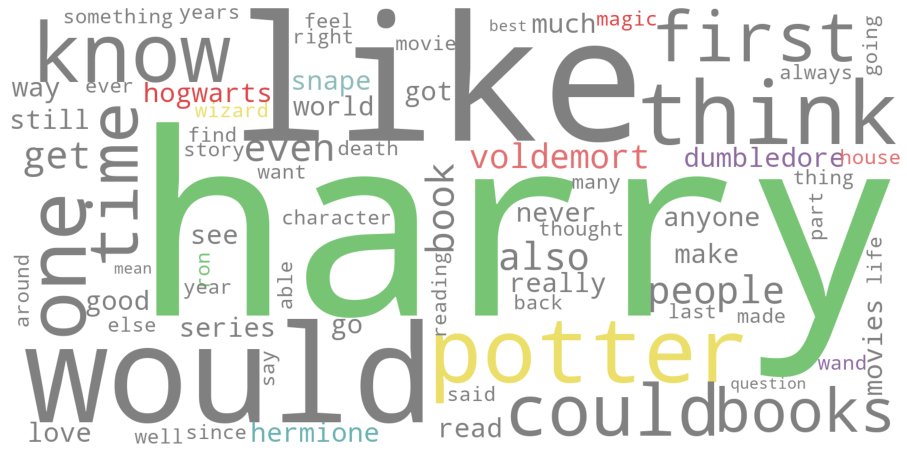

In [193]:
wordcloud = WordCloud(scale=4,background_color='white',color_func=colour_func_hp,random_state=42)
wordcloud.generate_from_frequencies(frequencies=dict(harry_freq[:75]))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Interpretation: The figures above shows some of the most frequently occuring words in r/harrypotter. The most frequent word in r/harrypotter is 'harry', referring to the name of the protagonist. Other interesting words include hogwarts, dumbledore, snape, hermione, voldemort and magic. Obviously these are referring to the name of places, characters or magic.

### Most Frequent Words in r/lotr

In [194]:
#lotr vocabulary
cvec.fit(clean_text_lotr)

CountVectorizer(binary=True)

In [195]:
word_freq = cvec.transform(clean_text_lotr)
word_freq.toarray().shape

(739, 5287)

In [196]:
word_freq_df = pd.DataFrame(word_freq.toarray(), columns=cvec.get_feature_names())
word_freq_df.shape

(739, 5287)

In [197]:
lotr_freq = sorted(list(zip(word_freq_df.sum().index,word_freq_df.sum())), key=lambda x : x[1],reverse=True)
lotr_freq[:20]

[('like', 90),
 ('one', 81),
 ('would', 80),
 ('know', 70),
 ('tolkien', 69),
 ('hobbit', 63),
 ('time', 62),
 ('earth', 61),
 ('middle', 61),
 ('books', 58),
 ('movies', 57),
 ('read', 56),
 ('first', 54),
 ('rings', 52),
 ('lord', 51),
 ('got', 47),
 ('book', 45),
 ('get', 44),
 ('think', 44),
 ('anyone', 43)]

In [198]:
counter = 0

def colour_func_lotr(word, font_size, position,orientation,random_state=None, **kwargs):
    global counter
    if counter == 7:
        counter = 0
    selected_colour = 'gray'
    lotr_words = ['tolkien','hobbit','middle','earth','rings','lord','gandalf','aragorn','fellowship','frodo','king',
                 'battle','sauron','elves','gollum','one']
    
    
    colors = ['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
    if word in lotr_words:
        
        #selected_colour = random.choice(colors)
        selected_colour = colors[counter]
        counter += 1
    
    return selected_colour

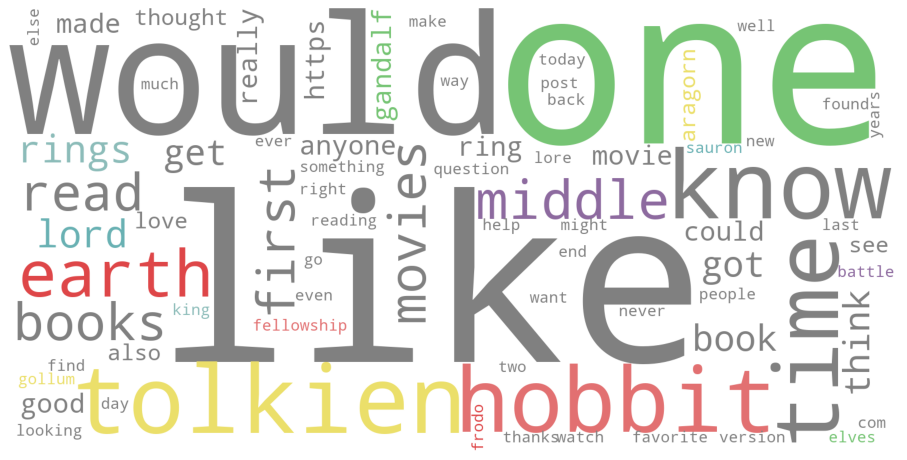

In [199]:
wordcloud = WordCloud(scale=4,background_color='white',color_func=colour_func_lotr,random_state=42)
wordcloud.generate_from_frequencies(frequencies=dict(lotr_freq[:75]))
plt.figure(figsize=(16,9))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Interpretation: The figures above shows some of the most frequently occuring words in r/lotr. The most frequent word in r/lotr is 'one', referring to the 'one ring' which is what the movie revolves around. Other interesting words include tolkien, hobbit, middle, earth,lord, rings, frodo and gandalf, for instance. Obviously these are referring to the name of places, characters, author and special items.

### Reddit Flairs

Reddit Flairs are tags of the post. They help filter categories based on the type of post it is. For example, discussion, announcement, question, events, news, etc. Each subreddit can have any custom flairs and they aren't consistent across the subreddits. Posts are not required to have flairs.

In [200]:
len(combined['link_flair_css_class'].unique())

23

In [201]:
flairs = combined['link_flair_css_class'].value_counts()
flairs

                    739
discussion          426
question            243
dungbomb             71
fanworks             57
misc                 40
help                 21
originalcontent      19
video                15
merchandise          14
fantasticbeasts      13
currentlyreading     12
TATTOO                9
cursedchild           8
behindthescenes       8
tattoo                5
announcement          5
parksvisit            5
news                  5
Discussion            3
Misc                  3
event                 1
points                1
Name: link_flair_css_class, dtype: int64

Interpretation: Across the r/harrypotter and r/lotr, there are a total of 22 unique flairs. The figure above shows the usage frequency for each flair. As can be seen, the majority of posts did not have flairs but for the ones that do, they usually are discussion or question.

In [202]:
flair_name = list(flairs.index)
flair_name[0] = 'No Flairs'

flair_freq = list(flairs)

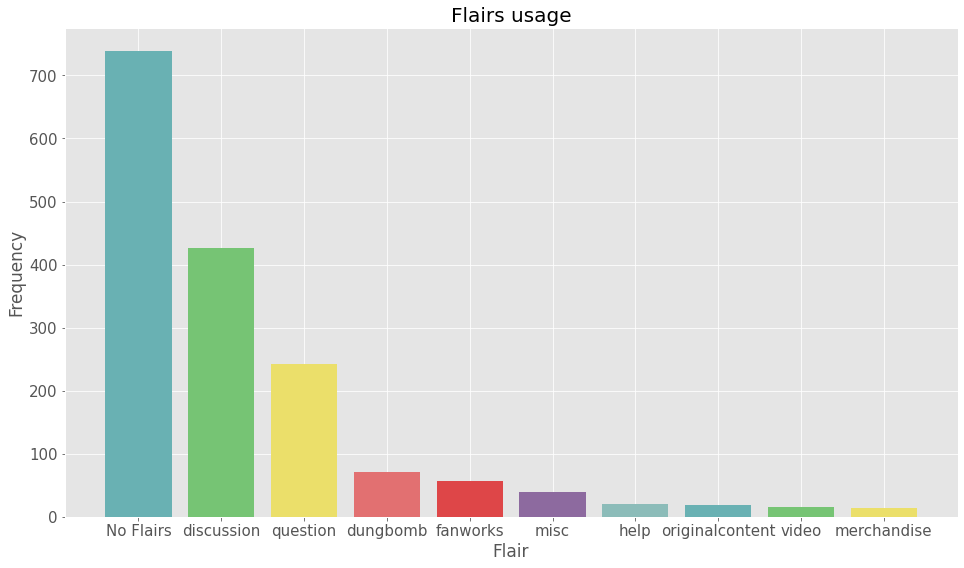

In [203]:
plt.figure(figsize=(16,9))
plt.bar(flair_name[:10],flair_freq[:10],color=['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9'])
plt.xlabel('Flair',size = 17)
plt.ylabel('Frequency',size = 17)
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Flairs usage',size = 20);

In [204]:
combined.loc[combined['is_harrypotter']==1]['link_flair_css_class'].value_counts()

discussion          426
question            243
dungbomb             71
fanworks             57
misc                 40
help                 21
originalcontent      19
video                15
merchandise          14
fantasticbeasts      13
currentlyreading     12
                      9
cursedchild           8
behindthescenes       8
announcement          5
parksvisit            5
tattoo                5
news                  5
Misc                  3
Discussion            3
event                 1
points                1
Name: link_flair_css_class, dtype: int64

In [205]:
combined.loc[combined['is_harrypotter']==0]['link_flair_css_class'].value_counts()

          730
TATTOO      9
Name: link_flair_css_class, dtype: int64

Interpretation: Upon further investigation, we found that the majority of the posts in our dataset that have flairs are from r/harrypotter with only 9 coming from r/lotr. This imbalance in the usage of flairs could compromise our prediction result if it were used as a feature to classify whether a post is from r/harrypotter or r/lotr. This was therefore not used as a feature despite the fact that it is text (which our model will be primarily using as a feature).

### Reddit Premium Users

In [206]:
combined.loc[combined['is_harrypotter']==1]['author_premium'].value_counts(normalize=True)

0    0.948171
1    0.051829
Name: author_premium, dtype: float64

In [207]:
combined.loc[combined['is_harrypotter']==0]['author_premium'].value_counts(normalize=True)

0    0.906631
1    0.093369
Name: author_premium, dtype: float64

Interpretation: The numbers above shows that in r/harrypotter, there is around 5% Premium Reddit users. In contrast, r/lotr boasts almost 10% - twice as much.

## Classification Models

We will be using three different classification algorithms in this project. These include Logistic Regression, kNN and Naive Bayes. The reason why these algorithms were picked is because they are highly scalable with the number of predictors which in this case there will be thousands of column vectors. Our text data will be vectorised using **TFIDF Vectorizers**. TFIDF is used because it does not simply just count the word occurance but also the overall document weightage of the word. GridSearch will be used in order to find the best hyperparameters for each of the models. We will then be evaluating the performance of these three models.

In [217]:
X = combined[['text']]
y = combined['is_harrypotter']

In [218]:
# Create train_test_split.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.20,
                                                    random_state = 42,
                                                    stratify=y,
                                                    shuffle = True)

In [219]:
X_train.shape

(1378, 1)

In [220]:
X_test.shape

(345, 1)

### Baseline Accuracy

In [221]:
combined['is_harrypotter'].value_counts(normalize=True)

1    0.571097
0    0.428903
Name: is_harrypotter, dtype: float64

Interpretation: The accuracy for the baseline model is 57%

In [222]:
def clean_text(text):  
    
    # 1. Remove non-letters.
    text = re.sub("[^a-zA-Z]", " ", text)
    text = text.lower()
    
    #Removing the word 'harrypotter' and 'lotr' from text to avoid the model learning from these words
    text = text.replace('harrypotter',' ')
    text = text.replace('lotr',' ')
    
    # 2. Convert to lower case, split into individual words.
    #words = letters_only.lower().split()
    
    tokenizer = RegexpTokenizer(r'\w+')
    words = tokenizer.tokenize(text)
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stopwords.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Stemming
    meaningful_words = [PorterStemmer().stem(w) for w in meaningful_words]
    
    # 6. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

In [223]:
# Example of original text
combined['text'][6]

'Just finished with The Sorcerer’s Stone for the first time! I just finished the book about half an hour ago and absolutely loved it! I never read them in school and decided to pick it up at Barnes and Noble on a whim, and I read through it in roughly 2 days! I plan on heading back to buy the next book tomorrow. I’m really curious to see how the story continues with Chamber of Secrets. Not much purpose to this post, but I wanted to share my enjoyment of the book and I was glad to find this subreddit!'

In [224]:
# Example of cleaned text
clean_text(combined['text'][6])

'finish sorcer stone first time finish book half hour ago absolut love never read school decid pick barn nobl whim read roughli day plan head back buy next book tomorrow realli curiou see stori continu chamber secret much purpos post want share enjoy book glad find subreddit'

In [225]:
# Cleaning all of the texts in the 'text' column
clean_text_train = [clean_text(txt) for txt in X_train['text']]
clean_text_test = [clean_text(txt) for txt in X_test['text']]

In [226]:
len(clean_text_train)

1378

In [227]:
len(clean_text_test)

345

In [228]:
# Function to make it easier to compute several evaluation metrics at once.

def print_metrics(tn, fp, fn, tp):
    acc = (tp+tn)/(tp+tn+fp+fn)
    mis = 1 - acc
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    precision = tp/(tp+fp)
    print(f'Accuracy: {round(acc,2)}')
    print(f'Misclassification Rate: {round(mis,3)}')
    print(f'Sensitivity: {round(sensitivity,3)}')
    print(f'Specificity: {round(specificity,3)}')
    print(f'Precision: {round(precision,3)}')
    

### Logistic Regression

In [229]:
pipeline = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear',max_iter=750))
])

In [99]:
pipeline.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()),
  ('logreg', LogisticRegression(max_iter=750, solver='liblinear'))],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'logreg': LogisticRegression(max_iter=750, solver='liblinear'),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'logreg__C': 1.0,
 'logreg__class_weight': None,
 'logreg__dual': False,
 'logreg__fit_intercept': True,
 'logreg__intercept_scaling': 1,
 'logreg__l1_ratio': None,
 'logreg__max

In [100]:
pipe_params = {
    'tvec__ngram_range': [(1, 1),(1,2),(1,3)],
    'tvec__max_features':[None, 5000, 7500],
    'tvec__max_df': [0.9,0.95,0.99],
    'tvec__min_df': [1,2,3],
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [0.5, 1, 50]
}

In [101]:
gs = GridSearchCV(pipeline,
                 param_grid=pipe_params,
                 cv=5)

In [102]:
gs.fit(clean_text_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg',
                                        LogisticRegression(max_iter=750,
                                                           solver='liblinear'))]),
             param_grid={'logreg__C': [0.5, 1, 50],
                         'logreg__penalty': ['l1', 'l2'],
                         'tvec__max_df': [0.9, 0.95, 0.99],
                         'tvec__max_features': [None, 5000, 7500],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [103]:
gs.best_params_

{'logreg__C': 50,
 'logreg__penalty': 'l2',
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1)}

In [104]:
# Cross val accuracy
gs.best_score_

0.8969591567852436

In [105]:
gs_model_logreg = gs.best_estimator_

#### Interpreting Coefficients

In [106]:
coef_list = list(zip(gs_model_logreg.steps[0][1].get_feature_names(),np.exp(gs_model_logreg.steps[1][1].coef_[0])))
coef_list = sorted(coef_list,key=lambda x : x[1],reverse=True)
coef_list[:5]

[('harri', 4228011.189181465),
 ('potter', 26838.452450829416),
 ('wizard', 5179.169432977958),
 ('hogwart', 1993.690755759082),
 ('weasley', 1068.672899070936)]

In [107]:
coef_list[-5:]

[('today', 0.0027188893893594058),
 ('gandalf', 0.0005456203929384769),
 ('tolkien', 0.0003603257113335751),
 ('hobbit', 0.00015272971917047805),
 ('ring', 0.00012205375648527239)]

Interpretation: One of the advantages of using Logistic Regression model is that it is parametic and so inferences can be made from the model. As can be seen here, if the text contains the word 'harry' (Stemmed word => harri), the the post is 4230000 times more likely to be from r/harrypotter. Other top four words that drastically increase the likelyhood of the post being from r/harrypotter are words like 'potter', 'wizard', 'hogwart' and 'weasley'. They increase the likelyhood by 27000, 5200, 2000 and 1100 respectively. As for words that pretty much almost guarantees that a post is from r/lotr are 'today','gandalf','tolkien','hobbit' and 'ring'. As you may remember from the wordcloud from earlier, these words are inconcidentally one of the most used words within the corresponding subreddits as well. They refer to the famous characters, place names and objects from each of the film.

#### Logistic Regression Model Evaluation

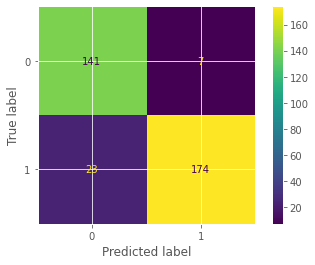

In [108]:
plot_confusion_matrix(gs_model_logreg,clean_text_test,y_test)

Interpretation: The confusion matrix above shows that the model's predictions have...
- 174 True Positives
- 141 True Negatives
- 7 False Positives
- 23 False Negatives

In [109]:
# Training Accuracy
gs_model_logreg.score(clean_text_train,y_train)

0.9992743105950653

In [110]:
# Testing Accuracy
gs_model_logreg.score(clean_text_test,y_test)

0.9130434782608695

In [111]:
# Training Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_train, gs_model_logreg.predict(clean_text_train))).ravel()

In [112]:
# Training Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 1.0
Misclassification Rate: 0.001
Sensitivity: 0.999
Specificity: 1.0
Precision: 1.0


In [113]:
# Testing Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_test, gs_model_logreg.predict(clean_text_test))).ravel()

In [114]:
# Testing Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 0.91
Misclassification Rate: 0.087
Sensitivity: 0.883
Specificity: 0.953
Precision: 0.961


In [115]:
#F1 Score Train
f1_score(y_train,gs_model_logreg.predict(clean_text_train))

0.9993642720915448

In [116]:
#F1 Score Test
f1_score(y_test,gs_model_logreg.predict(clean_text_test))

0.9206349206349206

Interpretation: This Logistic Regression performed very well with a small bias. There seems to be a slight overfit as the model's accuracy has reduced performance against unseen test set. The cross validation accuracy is on par with the testing set accuracy at 0.9 and 0.91 respectively. This is a decrease from the training set accuracy of 0.999. On the test set, the model has 8.7% misclassification rate. The model's precision is very high at 0.96 meaning that of all the positive class (r/harrypotter) the model predicted, it got the majority of them correct. The F1 Score on the test set is also high at 0.92, a slight reduction from the training's 0.99.

In the GridSearch, model performed best under the following conditions:

- 'logreg__C': 50
- 'logreg__penalty': 'l2'
- 'tvec__max_df': 0.9
- 'tvec__max_features': None
- 'tvec__min_df': 1
- 'tvec__ngram_range': (1, 1)

#### Further Analysis on the incorrectly predicted values

In [230]:
X_test_copy = X_test.copy(deep=True)
X_test_copy['pred'] = gs_model_logreg.predict(clean_text_test)
X_test_copy['actual'] = y_test
X_test_copy.head()

,text,pred,actual
6,Just finished with The Sorcerer’s Stone for th...,1,1
909,How were students and fighters able to apparat...,1,1
1079,"On March 12, 3019, Gollum betrayed Frodo and S...",0,0
2,snape,1,1
53,Let's show the magical artwork some respect! W...,1,1


In [231]:
incorrect_preds = X_test_copy.loc[X_test_copy['pred'] != X_test_copy['actual']]
incorrect_preds['text'].head(25)

997                            Some facts about The Lady 
924     Hi. I've painted this tshirt a while ago not t...
622     So I did another drawing, this time, of my eld...
718                                                 Awww 
901     I was reading my time magazine from 3 years ag...
1494    Why didn't more Rohan soldiers answer Theodens...
773                          Well that escalated quickly 
851                                                  😂😂😂 
644                                   I drew the gang :) 
1397    Spotted: our guys always make the cut when it ...
733     List of Harry Potter themed Escape rooms I am ...
1705    I have never watched Lotr I watched the first ...
46      Synch Book and Movie Has anyone ever played th...
671     When you find some good old stickers from earl...
1716                   Guys I think I found the Entwives 
24      This is disturbing Today I found out something...
875     Mispronouncing Tales of Beedle the Bard Up unt...
775     Not su

In [232]:
len(incorrect_preds)

30

Interpretation: There are 30 incorrect predictions on the test set. As the examples above show, the posts that have been misclassified do not contain some of the more popular words. Rather, they are more generic sentences (or even emojis). Noticeable Examples include:
-  What’s your favorite fanart piece or artist?
- 😂😂😂
- Lol 
-  Some facts about The Lady
- Awww 

##### Incorrect Predictions and 'Contains Media'

In [246]:
correct_preds_idx = [item for item in list(X_test.index) if item not in list(incorrect_preds.index)]

In [245]:
combined.iloc[correct_preds_idx]['contains_media'].mean()

0.34285714285714286

Interpretation: The number above shows that of all posts with the correct predictions, around 34% of them contain rich media such as videos, links and images. These posts generally have more descriptive titles and selftexts.

In [215]:
combined.iloc[incorrect_preds.index]['contains_media'].mean()

0.5333333333333333

Interpretation: The number above shows that of all posts with the incorrect predictions, around 53% of them contain rich media such as videos, links and images. This could explain the reason why these posts were incorrectly predicted due to the fact that a lot of posts with videos/images usally have very short titles and no selftext (text body).

### kNN

In [111]:
pipeline = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [112]:
pipeline.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('knn', KNeighborsClassifier())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'knn': KNeighborsClassifier(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 5,
 'knn__p': 2,
 'knn__weights': 'uniform'}

In [113]:
pipe_params = {
    'tvec__ngram_range': [(1, 1),(1,2),(1,3)],
    'tvec__max_features':[None, 5000, 7500],
    'tvec__max_df': [0.9,0.95,0.99],
    'tvec__min_df': [1,2,3],
    'knn__n_neighbors': [5,15,25],
    'knn__metric': ['minkowski','euclidean','manhattan']
}

In [114]:
gs = GridSearchCV(pipeline,
                 param_grid=pipe_params,
                 cv=5)

In [115]:
gs.fit(clean_text_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('knn', KNeighborsClassifier())]),
             param_grid={'knn__metric': ['minkowski', 'euclidean', 'manhattan'],
                         'knn__n_neighbors': [5, 15, 25],
                         'tvec__max_df': [0.9, 0.95, 0.99],
                         'tvec__max_features': [None, 5000, 7500],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [116]:
gs.best_params_

{'knn__metric': 'minkowski',
 'knn__n_neighbors': 15,
 'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [117]:
gs.best_score_

0.8555968379446641

In [118]:
gs_model_knn = gs.best_estimator_

#### kNN Model Evaluation

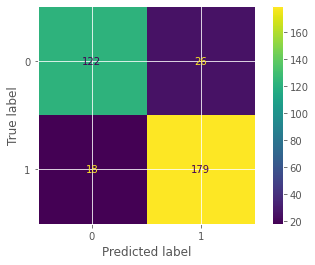

In [119]:
plot_confusion_matrix(gs_model_knn,clean_text_test,y_test)

Interpretation: The confusion matrix above shows that the model's predictions have...
- 179 True Positives
- 122 True Negatives
- 26 False Positives
- 18 False Negatives

In [120]:
gs_model_knn.score(clean_text_train,y_train)

0.8867924528301887

In [121]:
cross_val_score(gs_model_knn,clean_text_train,y_train,cv=5).mean()

0.8555968379446641

In [122]:
gs_model_knn.score(clean_text_test,y_test)

0.8724637681159421

In [123]:
#gs_model_knn[0].get_feature_names()

In [124]:
# Training Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_train, gs_model_knn.predict(clean_text_train))).ravel()

In [125]:
# Training Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 0.89
Misclassification Rate: 0.113
Sensitivity: 0.949
Specificity: 0.804
Precision: 0.866


In [126]:
# Testing Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_test, gs_model_knn.predict(clean_text_test))).ravel()

In [127]:
# Testing Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 0.87
Misclassification Rate: 0.128
Sensitivity: 0.909
Specificity: 0.824
Precision: 0.873


In [128]:
#F1 Score Train
f1_score(y_train,gs_model_knn.predict(clean_text_train))

0.9054545454545455

In [129]:
#F1 Score Test
f1_score(y_test,gs_model_knn.predict(clean_text_test))

0.8905472636815921

Interpretation: This kNN performed well, however with a slightly higher bias than the Logistic Model. There seems to be an overfit but to a lesser extent with the accuracy dropping from 0.89 in the training set to 0.87 in the testing set. On the test set, the model has higher misclassification rate at 13%. The model's precision is lower than Logistic Regression's precision at 0.87. The F1 Score on the test set is also high at 0.89, a slight reduction from the training's 0.91.

In the GridSearch, model performed best under the following conditions:

- 'knn__metric': 'minkowski'
- 'knn__n_neighbors': 15
- 'tvec__max_df': 0.9
- 'tvec__max_features': None
- 'tvec__min_df': 1
- 'tvec__ngram_range': (1, 2)

### Naive Bayes

In [130]:
pipeline = Pipeline([
    ('tvec',TfidfVectorizer()),
    ('nbayes', MultinomialNB())
])

In [131]:
pipeline.get_params()

{'memory': None,
 'steps': [('tvec', TfidfVectorizer()), ('nbayes', MultinomialNB())],
 'verbose': False,
 'tvec': TfidfVectorizer(),
 'nbayes': MultinomialNB(),
 'tvec__analyzer': 'word',
 'tvec__binary': False,
 'tvec__decode_error': 'strict',
 'tvec__dtype': numpy.float64,
 'tvec__encoding': 'utf-8',
 'tvec__input': 'content',
 'tvec__lowercase': True,
 'tvec__max_df': 1.0,
 'tvec__max_features': None,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 1),
 'tvec__norm': 'l2',
 'tvec__preprocessor': None,
 'tvec__smooth_idf': True,
 'tvec__stop_words': None,
 'tvec__strip_accents': None,
 'tvec__sublinear_tf': False,
 'tvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tvec__tokenizer': None,
 'tvec__use_idf': True,
 'tvec__vocabulary': None,
 'nbayes__alpha': 1.0,
 'nbayes__class_prior': None,
 'nbayes__fit_prior': True}

In [132]:
pipe_params = {
    'tvec__ngram_range': [(1, 1),(1,2),(1,3)],
    'tvec__max_features':[None, 5000, 7500],
    'tvec__max_df': [0.9,0.95,0.99],
    'tvec__min_df': [1,2,3]
}

In [133]:
gs = GridSearchCV(pipeline,
                 param_grid=pipe_params,
                 cv=5)

In [134]:
gs.fit(clean_text_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nbayes', MultinomialNB())]),
             param_grid={'tvec__max_df': [0.9, 0.95, 0.99],
                         'tvec__max_features': [None, 5000, 7500],
                         'tvec__min_df': [1, 2, 3],
                         'tvec__ngram_range': [(1, 1), (1, 2), (1, 3)]})

In [135]:
gs.best_params_

{'tvec__max_df': 0.9,
 'tvec__max_features': None,
 'tvec__min_df': 3,
 'tvec__ngram_range': (1, 2)}

In [136]:
gs.best_score_

0.8766271409749671

In [137]:
gs_model_nb = gs.best_estimator_

#### Naive Bayes Model Evaluation

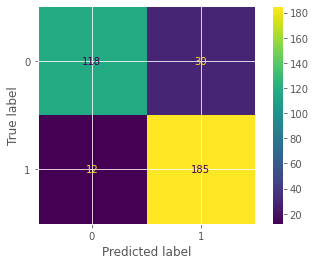

In [138]:
plot_confusion_matrix(gs_model_nb,clean_text_test,y_test)

Interpretation: The confusion matrix above shows that the model's predictions have...
- 185 True Positives
- 118 True Negatives
- 30 False Positives
- 12 False Negatives

In [139]:
gs_model_nb.score(clean_text_train,y_train)

0.951378809869376

In [140]:
cross_val_score(gs_model_nb,clean_text_train,y_train,cv=5).mean()

0.8766271409749671

In [141]:
gs_model_nb.score(clean_text_test,y_test)

0.8782608695652174

In [142]:
gs_model_nb.steps

[('tvec', TfidfVectorizer(max_df=0.9, min_df=3, ngram_range=(1, 2))),
 ('nbayes', MultinomialNB())]

In [143]:
gs_model_nb[0].get_feature_names()

['ab',
 'abandon',
 'aberforth',
 'abil',
 'abl',
 'abl get',
 'abl make',
 'abl use',
 'absolut',
 'absolut beauti',
 'absolut perfect',
 'abt',
 'abus',
 'accept',
 'access',
 'accid',
 'accident',
 'accompani',
 'accord',
 'account',
 'accur',
 'achiev',
 'across',
 'acryl',
 'act',
 'act like',
 'action',
 'activ',
 'actor',
 'actual',
 'actual hear',
 'actual see',
 'ad',
 'adapt',
 'add',
 'addict',
 'addit',
 'address',
 'admir',
 'admit',
 'ador',
 'adult',
 'advanc',
 'adventur',
 'advertis',
 'advic',
 'advis',
 'affect',
 'afraid',
 'aftermath',
 'afterward',
 'age',
 'agenda',
 'ago',
 'agre',
 'agre movi',
 'ahead',
 'aid',
 'air',
 'aka',
 'alan',
 'albu',
 'albu dumbledor',
 'albu severu',
 'alert',
 'alien',
 'align',
 'aliv',
 'alley',
 'allow',
 'almost',
 'alon',
 'along',
 'alongsid',
 'alot',
 'alreadi',
 'alreadi establish',
 'alright',
 'also',
 'also could',
 'also know',
 'also like',
 'also love',
 'also made',
 'also make',
 'also read',
 'also see',
 'also t

In [144]:
# Training Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_train, gs_model_nb.predict(clean_text_train))).ravel()

In [145]:
# Training Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 0.95
Misclassification Rate: 0.049
Sensitivity: 0.983
Specificity: 0.909
Precision: 0.935


In [146]:
# Testing Set Metrics
tn, fp, fn, tp = (confusion_matrix(y_test, gs_model_nb.predict(clean_text_test))).ravel()

In [147]:
# Testing Set Metrics
print_metrics( tn, fp, fn, tp)

Accuracy: 0.88
Misclassification Rate: 0.122
Sensitivity: 0.939
Specificity: 0.797
Precision: 0.86


In [148]:
#F1 Score Train
f1_score(y_train,gs_model_nb.predict(clean_text_train))

0.958513931888545

In [149]:
#F1 Score Test
f1_score(y_test,gs_model_nb.predict(clean_text_test))

0.8980582524271845

Interpretation: This Naive Bayes model performed better than kNN, however it has a slightly higher bias than the Logistic Model. There seems to be an overfit similar to Logistic Regression model with the accuracy dropping from 0.95 in the training set to 0.88 in the testing set. On the test set, the model has higher misclassification rate at 12%. 

In the GridSearch, model performed best under the following conditions:

- 'tvec__max_df': 0.9,
- 'tvec__max_features': None,
- 'tvec__min_df': 3,
- 'tvec__ngram_range': (1, 2)

## Model Comparison

In [150]:
l_perf = (confusion_matrix(y_test, gs_model_logreg.predict(clean_text_test))).ravel()
knn_perf = (confusion_matrix(y_test, gs_model_knn.predict(clean_text_test))).ravel()
nb_perf = (confusion_matrix(y_test, gs_model_nb.predict(clean_text_test))).ravel()
tn, fp, fn, tp
l_perf = [l_perf[3],l_perf[1],l_perf[0],l_perf[2]]
knn_perf = [knn_perf[3],knn_perf[1],knn_perf[0],knn_perf[2]]
nb_perf = [nb_perf[3],nb_perf[1],nb_perf[0],nb_perf[2]]

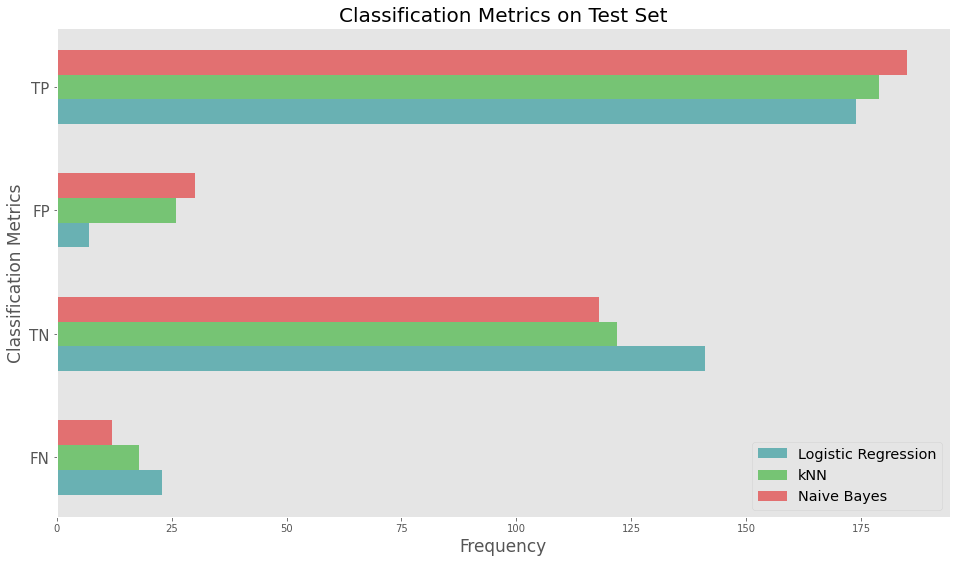

In [151]:
ind = np.arange(4)  # the x locations for the groups
width = 0.20       # the width of the bars

fig = plt.figure(figsize=(16,9))
ax = fig.add_subplot(111)
rects1 = ax.barh(ind, l_perf[::-1], width, color='#69b1b3')
rects2 = ax.barh(ind+width,knn_perf[::-1], width, color='#76c474')
rects3 = ax.barh(ind+2*width, nb_perf[::-1], width, color='#e27071')

#['#69b1b3','#76c474','#ebdf6a','#e27071','#de4648','#8D6A9F','#8CBCB9']
# add some
ax.set_ylabel('Classification Metrics', size = 17)
ax.set_xlabel('Frequency', size = 17)
ax.set_title('Classification Metrics on Test Set', size = 20)
ax.set_yticks(ind + width )
ax.set_yticklabels(['TP', 'FP', 'TN', 'FN'][::-1],size=15)
ax.legend( (rects1[0], rects2[0],rects3[0]), ('Logistic Regression', 'kNN','Naive Bayes'),fontsize = 'x-large')
plt.grid(axis='both',which='both',alpha=0.5)
plt.show()

Interpretation: The above diagram shows the number of TP, FP, TN and FN for each of the classification model on the test dataset. It clearly shows that although Naive Bayes has the highest number of True Positives, it also has the highest number of False Positives. Logistic Regression, on the other hand, has the similar number of True Positive as other models but it also has the lowest number of False Positives by far. When it comes to True Negative, Logistic Regression performed the best with almost 30 more correct negative prediction (predicting the post is from r/lotr). Logistic Regression does have a slightly higher False Negatives than the other two models.

### ROC & AUC

In [152]:
# ROC LogisticRegression
logreg_fpr, logreg_tpr, thresh = roc_curve(y_test, gs_model_logreg.predict_proba(clean_text_test)[:,1])

In [153]:
logreg_auc = auc(logreg_fpr,logreg_tpr)
logreg_auc

0.9723556043352998

In [154]:
# ROC KNN
knn_fpr, knn_tpr, thresh = roc_curve(y_test, gs_model_knn.predict_proba(clean_text_test)[:,1])

In [155]:
knn_auc = auc(knn_fpr,knn_tpr)
knn_auc

0.9480552887913293

In [156]:
# ROC NB
nb_fpr, nb_tpr, thresh = roc_curve(y_test,gs_model_nb.predict_proba(clean_text_test)[:,1])

In [157]:
nb_auc = auc(nb_fpr,nb_tpr)
nb_auc

0.9666277953079984

Text(0.5, 1.0, 'ROC Curve')

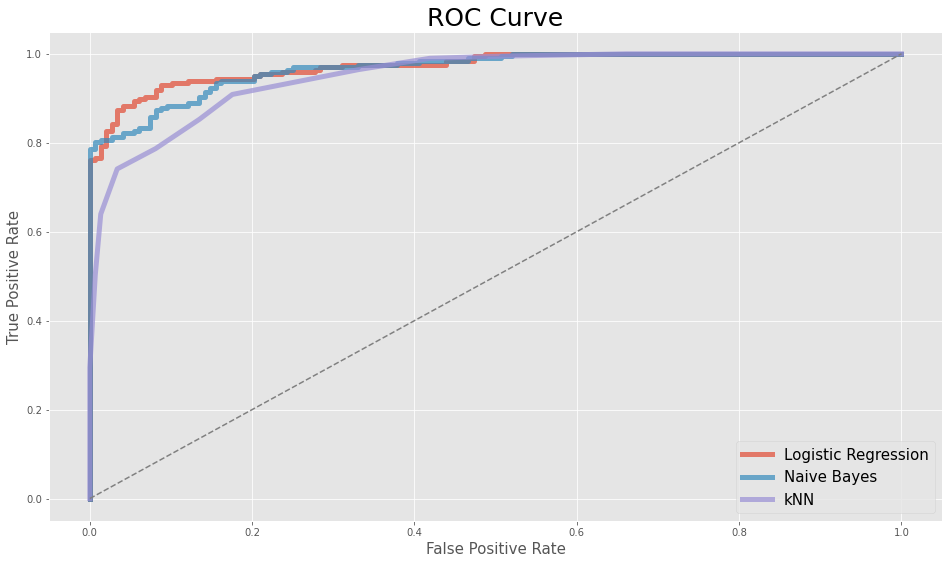

In [158]:
plt.figure(figsize=(16,9))
plt.plot(logreg_fpr,logreg_tpr,label='Logistic Regression',linewidth=5,alpha=0.7)
plt.plot(nb_fpr,nb_tpr,label='Naive Bayes',linewidth=5,alpha=0.7)
plt.plot(knn_fpr,knn_tpr,label='kNN',linewidth=5,alpha=0.7)
plt.plot([0,1],[0,1],color='gray',linestyle = 'dashed')
plt.xlabel('False Positive Rate',size=15)
plt.ylabel('True Positive Rate',size=15)
plt.legend(fontsize=15)
plt.title('ROC Curve',size=25)

Interpretation: The ROC diagram above illustrates the performance of the three models (Logistic Regression, Naive Bayes and kNN). The dotted line displays the baseline. It can be clearly seen that kNN performed the worst in terms of the True Positive Rate and False Positive Rate across all of the thresholds. The AUC for kNN here is 0.948. Naive Bayes model performed second best with the AUC of 0.967. The Logistic Regression performed the best with a slight win over Naive Bayes. It scored 0.972.

## Evaluation

|          Metrics       | Logistic Regression | kNN | Naive Bayes |
|------------------------|---------------------|-----|-------------|
| Accuracy (Train) |          1         |  0.89   |       0.95      |
| Accuracy (Test)               |      0.91               |   0.87  |   0.88          |
| Misclassification Rate (Train)|         0            |   0.11  |    0.05         |
| Misclassification Rate (Test) |           0.09          |   0.13  |       0.12      |
| Sensitivity (Train)             |          1           |  0.95   |      0.98       |
| Sensitivity (Test)            |            0.88         |  0.91   |        0.94     |
| Specificity (Train)            |             1        |   0.80  |          0.91   |
| Specificity (Test)            |               0.95      |   0.82  |      0.80       |
| Precision (Train)              |              1       |    0.87 |        0.94     |
| Precision (Test)              |               0.96      |   0.87  |       0.86      |
| F1 (Train)                     |     1                |   0.91  |    0.96         |
| F1 (Test)                     |         0.92            |   0.89  |      0.90       |
| AUC  |0.972|0.948|0.967|

#### Evaluation
Overall, the three models performed much better than the baseline model which has an accuracy of 57%. Their accuracies were all above 85% with Logistic Regression edging ahead the other two at 91% on unseen dataset. However, it can be seen that eventhough both Logistic Regression and Naive Bayes may have low bias, their variance is much higher than kNN. When we look at the misclassification rate, we can clearly see that Naive Bayes and kNN have similar performance at 12-13% while Logistic Regression has under 10%. Here both subreddits have equal importance so incorrectly predicting one class or other doesn't really matter. This is unlike, for example, medical check where predicting whether a patient has cancer or not has grave consequence if the model has high False Negative Rate. This means that here we treat FPR and FNR equally. Therefore, we try to optimise the model for accuracy in general. The ROC Curve and the AUC also helped us verify that Logistic Regression model does indeed perform the best, marginally better than Naive Bayes in terms of the AUC at 0.972 and 0.967 respectively.

In which case, the best performing model is the Logistic Regression Model which score the highest accuracy in both the training and testing datasets at 100% and 91% respectively. The model has lower bias than its counterparts and while it may be overfitted, it still outperforms the other models on unseen data. This had been helped in part by the l2 regularisation which helped to simplify the model's complexity leading to a more acceptable result. GridSearch was done in order to see whether simplifying the model through limiting the number of features obtained from DFIDF Vectorisers would result in a better model. However, GridSearch showed that the best Logistic Model found was one where DFIDF had no feature limits and ngram is set to (1,1).



#### Limitations
The main limitation of the model is that it is currently only performing tokenisation, stopwords removal, stemming and dfidf vectorisation. This is a very simple method that does not seek to understand the context or the meaning of these sentences. We are only looking at word occurances and using that information to classify. Therefore, meanings are lost with this type of process. Improvements could be made by using more NTL techniques that are able to understand the context or able to group relevant words together to provide better context. Additionally, since many of the posts contain videos and image, we could improve the model by making use of these features as well.

## Conclusion

In conclusion, the project showed that we are able to make predictions on whether a post belongs to r/harrypotter or r/lotr. This could be a good start for the future work that could ease the ever increasing burden on the subreddit moderators across the network. Although our current model is only able to classify between two subreddits. The production model would only need to classify whether a post belongs in the subreddit (1) or it doesn't, ie. one-vs-all approach. In which case, the output would be 0. In our case 1 represented a post belonging to r/harrypotter and 0 represented a post belonging to r/lotr. Reddit could employ such strategy to remove spams and irrelavant content through this process in detecting whether a post belong in the subreddit or not. However, the effectiveness would very much depend on the quality of the texts/selftexts and whether it contains other rich media.